In [42]:
import random
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
from scipy.special import erfinv
from scipy.integrate import quad
from scipy.stats import poisson
%matplotlib inline

## Utility Functions

In [43]:
def find_max(function, bound_low, bound_high, grid=100000,):
    """
    Return the maximum value of a function
    """
    if (not grid >= 0):
        raise ValueError("Grid must be a a positive intiger")
    # Generate grid of x values
    x = np.linspace(bound_low, bound_high, num=grid, endpoint=True,)
    y = function(x)
    return y.max()

def find_significance(pdf, interval_limits):
    """
    Compute the p_value and significance value of a interval
    """

    # Compute integrals
    full_integral = pdf.integrate( (pdf.boundMin, pdf.boundMax) )
    interval_integral = pdf.integrate(interval_limits)

    # Compute p value of probability
    p_value = interval_integral/full_integral

    n_sigma = compute_z_score(p_value)

    return (p_value, n_sigma) 

def compute_z_score(p_value):
    """
    Compute significance value from p_value
    """

    # Compute Z score
    n_sigma = np.sqrt(2) * erfinv(1 - p_value)

    return n_sigma

def compute_time_of_flight(momentum, particle, length=20.0, light_speed=1,):
    match particle:
        case "pion": 
            mass = 139.6        # MeV/c
        case "kaon":
            mass = 493.7        # MeV/c
        case _:
            raise ValueError("String provided for particle invalid. Must be 'muon' of 'kaon'")
    return (length/light_speed) * np.sqrt(1+(mass*light_speed/momentum)**2)     # Output is in nano seconds

## Classes

### Parent Classes

In [44]:
class ProbabilityDensityFunction(object):
    """
    Parent class containing common methods and members to be used by all pdf classes
    """

    def __init__(self, bounds):

        if (not isinstance(bounds, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (boundMin, boundMax)")
        if (not len(bounds) == 2):
            raise ValueError("Variable bound must have form (boundMin, boundMax)")
        if (not bounds[0] < bounds[1]):
            raise ValueError("First element in tuple must be smaller than second")
        
        # Initialise class variables
        self.boundMin, self.boundMax = bounds
        # Initialise list to hold randomly generated mass values
        self.mass = []

    def integrateBounded(self, limits):
        """
        Evaluate the integral of the pdf within the specified bounds
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not isinstance(limits, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (limitMin, limitMax)")
        if (not len(limits) == 2):
            raise ValueError("Variable bound must have form (limitMin, limitMax)")
        if (not limits[0] < limits[1]):
            raise ValueError("First element in tuple must be smaller than second")
        if (not limits[0] >= self.boundMin):
            raise ValueError("Lower integral limit must be larger than lower bound of pdf")
        if (not limits[1] <= self.boundMax):
            raise ValueError("Higher integral limit must be smaller than upper bound of pdf")
    
        lowerLimit, upperLimit = limits
        integralResult, IntegralError = quad(self._evaluate, lowerLimit, upperLimit) 
        return integralResult

    def getMass(self,):
        """
        Return numpy array containing all generated values
        """

        return np.array(self.mass)
    

### Child Classes

In [45]:
class Flat(ProbabilityDensityFunction):

    """
    Class that will generate a random value according to a flat distribution using a uniform method
    """

    def __init__(self, yIntercept, bounds):

        # Initialise parent class
        super().__init__(bounds)

        # Initialise class variables
        self.yIntercept = yIntercept                              # y intercept of flat function
 
        # Find maximum value of the distribution within the bounds
        self.maxValue = find_max(self._evaluate, self.boundMin, self.boundMax)

    def _evaluate(self, x,):
        """
        Evaluate the flat function of the distribution
        NOTE: Returns un-normalised values
        """
        
        return np.array(self.yIntercept)    # requirtred as some methods require output of evaluate to be a numpy array 

    # def next(self,):
    #     """
    #     Generate a single random variable according to the class' distribution using numpy.random.normal method
    #     Will return and append generated variable to mass list.
    #     """

    #     # Use .item() to append variable inside array and not array itself
    #     x = np.random.uniform(low=self.boundMin, high=self.boundMax, size=1).item()
    #     self.mass.append(x)
    #     return x

    def next(self,):
        """
        Generate a single random variable according to the class' distribution using the box method.
        Will return and append generated variable to mass list.
        """

        # Iterate untill a random value within the distribution is generated
        while True:
            # Generate random x variable within the distribution's bounds
            x = random.uniform(self.boundMin, self.boundMax)
            # Evaluate y value for x and the maximum y value allowed by the system
            y1 = self._evaluate(x)
            y2 = random.uniform(0, self.maxValue)
            # Accept x if y2 is less than y1
            if (y2<y1):
                filteredX = x
                self.mass.append(filteredX)
                return filteredX

    def generateEvents(self, nEvents):
        """
        Generate specified number of events and store them in self.mass
        """

        if not isinstance(nEvents, int):
            raise ValueError("Number of events must be type int")
        
        if (not nEvents > 0):
            raise ValueError("Number of events must be a positive integer") 

        # Iterate over number of specidied events
        for _ in range(nEvents):
            _ = self.next()

    def getObservedEvents(self,numberBins):
        """
        Compute and return the number of observed events and bins for a pdf using simulated 
        """

        nObservedEvents, bins , _ = plt.hist(self.mass, bins=numberBins)
        xBins = ( bins + (bins[1]-bins[0])/2 )[:-1]          # Center-point value of bins (Eliminate last element)

        return xBins, nObservedEvents
        
    def setParameters(self, yIntercept=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not yIntercept == None:               self.yIntercept = yIntercept  

    def integrateAbove(self, lowerLimit,):
        """
        Evaluate the integral of the pdf between specified value and positive infinity.
        Here we define positive infinity to be 7 sigma above the mean (to include ~100% of gaussian)
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not lowerLimit >= self.boundMin):
            raise ValueError("Lower integral limit must be larger than lower bound of pdf")
        if (not lowerLimit <= self.boundMax):
            raise ValueError("Lower integral limit must be smaller than upper bound of pdf")
        
        upperLimit = self.mean + 10*self.sigma
        integralResult, IntegralError = quad(self._evaluate, lowerLimit, upperLimit) 
        return integralResult

    def integrateBelow(self, upperLimit,):
        """
        Evaluate the integral of the pdf between specified value and negative infinity.
        Here we define positive infinity to be 7 sigma below the mean (to include ~100% of gaussian)
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not upperLimit >= self.boundMin):
            raise ValueError("Upper integral limit must be larger than lower bound of pdf")
        if (not upperLimit <= self.boundMax):
            raise ValueError("Upper integral limit must be smaller than upper bound of pdf")
        
        lowerLimit = self.mean - 10*self.sigma
        integralResult, IntegralError = quad(self._evaluate, lowerLimit, upperLimit) 
        return integralResult


class Gaussian(ProbabilityDensityFunction):
    """
    Class that will generate a random value according to a gaussian distribution using numpy.random.normal
    """

    def __init__(self, mean, sigma, bounds):

        # Initialise parent class
        super().__init__(bounds)
        
        # Initialise class variables
        self.mean = mean
        self.sigma = sigma
        # Find maximum value of the distribution within the bounds
        self.maxValue = find_max(self._evaluate, self.boundMin, self.boundMax)

    def _evaluate(self, x,):
        """
        Evaluate the gaussian function of the distribution
        ##### NOTE: Returns un-normalised values between the bounds #####
        """

        return 1/(self.sigma * np.sqrt(2.0*np.pi)) * np.exp( -(x-self.mean)**2 / (2.0 * self.sigma**2) )

    def next(self,):
        """
        Generate a single random variable according to the class' distribution using numpy.random.normal method
        Will return and append generated variable to mass list.
        """

        # Use .item() to append vsariable inside array and not array itself
        x = np.random.normal(self.mean, self.sigma, size=1).item()
        self.mass.append(x)
        return x

    def generateEvents(self, nEvents):
        """
        Generate specified number of events and store them in self.mass
        """

        if not isinstance(nEvents, int):
            raise ValueError("Number of events must be type int")
        
        if (not nEvents > 0):
            raise ValueError("Number of events must be a positive integer") 

        # Iterate over number of specidied events
        for _ in range(nEvents):
            _ = self.next()

    def getObservedEvents(self,numberBins):
        """
        Compute and return the number of observed events and bins for a pdf using simulated 
        """

        nObservedEvents, bins , _ = plt.hist(self.mass, bins=numberBins)
        xBins = ( bins + (bins[1]-bins[0])/2 )[:-1]          # Center-point value of bins (Eliminate last element)

        return xBins, nObservedEvents

    def setParameters(self, mean=None, sigma=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not mean == None:                self.mean = mean 
        if not sigma == None:               self.sigma = sigma

    def integrateAbove(self, lowerLimit,):
        """
        Evaluate the integral of the pdf between specified value and positive infinity.
        Here we define positive infinity to be 7 sigma above the mean (to include ~100% of gaussian)
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not lowerLimit >= self.boundMin):
            raise ValueError("Lower integral limit must be larger than lower bound of pdf")
        if (not lowerLimit <= self.boundMax):
            raise ValueError("Lower integral limit must be smaller than upper bound of pdf")
        
        upperLimit = self.mean + 10*self.sigma
        integralResult, IntegralError = quad(self._evaluate, lowerLimit, upperLimit) 
        return integralResult

    def integrateBelow(self, upperLimit,):
        """
        Evaluate the integral of the pdf between specified value and negative infinity.
        Here we define positive infinity to be 7 sigma below the mean (to include ~100% of gaussian)
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not upperLimit >= self.boundMin):
            raise ValueError("Upper integral limit must be larger than lower bound of pdf")
        if (not upperLimit <= self.boundMax):
            raise ValueError("Upper integral limit must be smaller than upper bound of pdf")
        
        lowerLimit = self.mean - 10*self.sigma
        integralResult, IntegralError = quad(self._evaluate, lowerLimit, upperLimit) 
        return integralResult


class ROC(object):
    """
    Class which will compute the ROC parameters of two particle hypothesese given a measured particle momentum
    """

    def __init__(self, momentum, sigma, nStep=100, nEvents=10000):

        # Find mean time of flight for both particles
        mean_kaon = compute_time_of_flight(momentum, "kaon")
        mean_pion = compute_time_of_flight(momentum, "pion")

        # Compute 10 sigma bounds
        bounds_kaon = (mean_kaon - 10*sigma, mean_kaon + 10*sigma)
        bounds_pion = (mean_pion - 10*sigma, mean_pion + 10*sigma)

        # Initialise pdf objects for both particles
        self.pdf_kaon = Gaussian(mean_kaon, sigma, bounds_kaon)
        self.pdf_pion = Gaussian(mean_pion, sigma, bounds_pion)

        # Generate events for both particle pdfs
        self.pdf_kaon.generateEvents(nEvents)
        self.pdf_pion.generateEvents(nEvents)

        # Define array containing tCut values at each performance point
        self.performancePoints = np.linspace(mean_pion, mean_kaon, nStep, endpoint=True)

        # Initialise empty lists to hold alpha and beta values
        self.alphaValues = []
        self.betaValues = []

    def _plotDistributions(self, tCut):
        """
        Plot the  distributuions for kaons and pions
        """
        
        kaonEvents = self.pdf_kaon.getMass()
        pionEvents = self.pdf_pion.getMass()

        plt.hist(kaonEvents, bins=100, color="blue", alpha=0.5)
        plt.hist(pionEvents, bins=100, color="red", alpha=0.5)
        plt.vlines(tCut, 0, 300, linestyles="dashed")
        plt.show()

    def _computeErrors(self, tCut):
        """
        Compute the alpha and beta values for both hypothese
        """

        # We choose that particle being a kaon is out null hypothesis. We also choose pion as our alternative
        # hypothesis. As such alpha is kaon area below tCut and beta is pion area above tCut

        alpha = self.pdf_kaon.integrateBelow(tCut,)
        beta = self.pdf_pion.integrateAbove(tCut,)

        return (alpha, beta)
        
    def computeROC(self,):
        """
        Compute alpha and beta values for all performance points defined in class
        """

        for tCut in self.performancePoints:
            alpha, beta = self._computeErrors(tCut)
            self.alphaValues.append(alpha)
            self.betaValues.append(beta)

    def getAlphas(self,):
        """
        Return alpha values of ROC
        """      

        return self.alphaValues

    def getBetas(self,):
        """
        Return beta values of ROC
        """      

        return self.betaValues

## Excercises

Below are the 4 excersices for the checkpoint

### Excercise 1

In [46]:
CLAIMED_FAULTY_RATE = 0.05
ACTUAL_FAULTY_RATE = 0.15
# Pick a sufficiently large limit
SAMPLE_SIZE = 100
X_CUT = 9


x = np.arange(0, 100, 1,)
claimed_faulty_distribution = binom(SAMPLE_SIZE, CLAIMED_FAULTY_RATE)
actual_faulty_distribution = binom(SAMPLE_SIZE, ACTUAL_FAULTY_RATE)

# Compute Type-I error 
x_mask_type_1 = x > X_CUT
type_1_error = claimed_faulty_distribution.pmf(x)[x_mask_type_1].sum()

# Compute Type 2 mask
# Not that the mask used is the inverse of the mask calculated above
x_mask_type_2 = ~ x_mask_type_1
type_2_error = actual_faulty_distribution.pmf(x)[x_mask_type_2].sum()

print(f"The type I error is {type_1_error:.3f}")
print(f"The type II error is {type_2_error:.3f}")

The type I error is 0.028
The type II error is 0.055


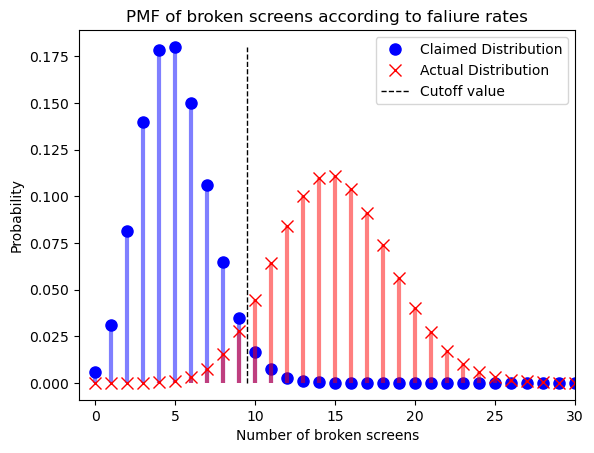

In [47]:
fig, ax = plt.subplots(1, 1)

# Plot claimed distribution
ax.plot(x, claimed_faulty_distribution.pmf(x), 'bo', ms=8, label='Claimed Distribution')
ax.vlines(x, 0, claimed_faulty_distribution.pmf(x,), colors='b', lw=3, alpha=0.5)

ax.plot(x, actual_faulty_distribution.pmf(x), 'rx', ms=8, label='Actual Distribution')
ax.vlines(x, 0, actual_faulty_distribution.pmf(x,), colors='r', lw=3, alpha=0.5)
ax.vlines(X_CUT+0.5, 0, claimed_faulty_distribution.pmf(x).max(), colors="black", linestyles="--", label="Cutoff value", lw=1)

plt.legend()
plt.xlabel("Number of broken screens")
plt.ylabel("Probability")
plt.title("PMF of broken screens according to faliure rates")
plt.xlim(-1, 30)
plt.show()

### Excercise 2

[]

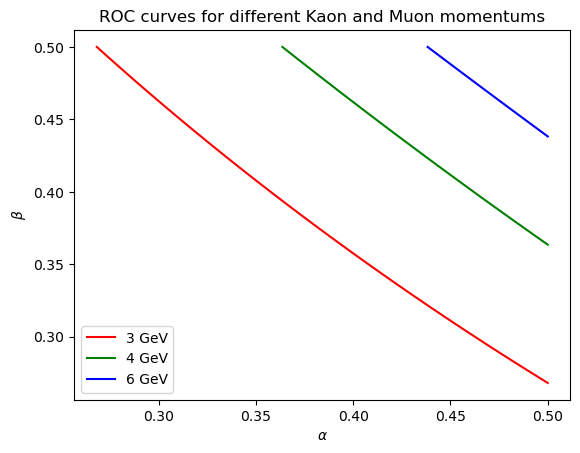

In [48]:
MASS_KAON = 493.7           # MeV/c**2
MASS_PION = 139.6
DISTANCE = 20.0             # m
SPEED_LIGHT = 1             # Natural units
SIGMA = 0.400               # ns
MOMENTUMS = [3e3, 4e3, 6e3]
COLORS = ["red", "green", "blue"]
LINESTYLE = ["-", "--", ".."]

# Initialise ROC classes for each momentum of choice

low_momentum_roc = ROC(MOMENTUMS[0], SIGMA,) 
medium_momentum_roc = ROC(MOMENTUMS[1], SIGMA,)
high_momentum_roc = ROC(MOMENTUMS[2], SIGMA,)

# Create list containing all ROC objects
roc_objects = [
    low_momentum_roc,
    medium_momentum_roc,
    high_momentum_roc
]

fig, ax = plt.subplots(1, 1)

# Iterate over all ROCs, compute and plot the alphas and betas
for idx, roc in enumerate(roc_objects):

    roc.computeROC()
    alphas = roc.getAlphas()
    betas = roc.getBetas()

    ax.plot(alphas, betas, c=COLORS[idx], label=f"{int(MOMENTUMS[idx]/1e3)} GeV",)

ax.set_ylabel(r"$\beta$")
ax.set_xlabel(r"$\alpha$")
ax.set_title("ROC curves for different Kaon and Muon momentums")
ax.legend()
plt.plot()

ajhbaja


### Excercise 3

Total number of events: 43.0
Number of bins: 50


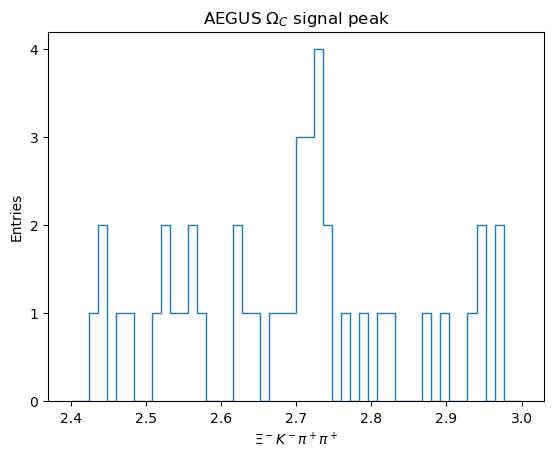

In [49]:
N_BINS = 50
X_MIN = 2.4         # GeV
X_MAX = 3.0         # GeV
bins = np.linspace(X_MIN, X_MAX, N_BINS) 
counts = np.array([
    0,0,1,2,0,1,1,0,0,1,2,1,1,2,1,0,0,0,2,1,1,0,1,1,1,
    3,3,4,2,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,2,0,2,0,0,
]).astype(float)

total = counts.sum()
print(f"Total number of events: {total}\nNumber of bins: {counts.size}")

events, _, _ = plt.hist(bins, bins=counts.size, weights=counts, histtype="step", range=(bins.min(), bins.max()))
plt.xlabel(r"$\Xi^- K^- \pi^+ \pi^+$")
plt.ylabel("Entries")
plt.title(r"AEGUS $\Omega_C$ signal peak")
plt.yticks(np.arange(0, counts.max()+1,))
plt.show()

#### Excersice 3.1

In [50]:
# Compute mean event count assuming all signals are bouckground
mean_event_background = events.mean()
print(f"Number of events per bin assuming all events are background is {mean_event_background} events per bin")

# Find bin value of hitogram peak
peak_index = np.argmax(events)
events_peak = events[peak_index]
energy_peak = bins[peak_index]
print(f"Peak of histogram is found at {energy_peak:.3f} GeV with {int(events_peak)} counts")

# Compute a 2.5 sigma window from the peak and create a mask
SIGMA = 12e-3
window_bounds = (energy_peak - 2.5*SIGMA, energy_peak + 2.5*SIGMA)
window_mask = (bins >= window_bounds[0]) & (bins <= window_bounds[1])

# Compute number of events inside window
observed_background_events = events[window_mask].sum()
print(f"Number of events inside window centerd at peak: {int(observed_background_events)} events")

# Estimating the number of background events within the window
# Using average event count per bin assuming hist is background and multiplying by number of bins within window
expected_background_events = mean_event_background*window_mask.sum()

# Initialise poison object with mean at Nobs
poisson_events = poisson(expected_background_events)
p_value = poisson_events.sf(observed_background_events)
significance = compute_z_score(p_value)
print(f"The significance of there being {int(observed_background_events)} given an an expected event count of {expected_background_events} is {significance:.3f} sigma")


Number of events per bin assuming all events are background is 0.86 events per bin
Peak of histogram is found at 2.731 GeV with 4 counts
Number of events inside window centerd at peak: 12 events
The significance of there being 12 given an an expected event count of 4.3 is 3.463 sigma


#### Excercise 3.2

array([6.81404478, 3.58523352, 4.46123339, 2.70940555, 4.83460613,
       4.79736114, 2.99196473, 2.5302799 , 9.82615156, 3.83879272,
       2.1987102 , 8.72717076, 4.35394503, 6.28457461, 3.54717059,
       7.73679322, 6.88987394, 0.01774155, 2.84811503, 5.04849337,
       9.2905438 , 2.47942785, 6.40054876, 4.56954763, 6.35861152,
       3.76963006, 7.58621998, 9.04427457, 9.35329608, 2.83145854,
       8.70542705, 2.43410468, 7.15780908, 2.07365391, 1.87095889,
       0.73945017, 7.58730112, 1.69062466, 6.60048908, 6.11322802,
       2.06519059, 0.48809746, 0.23754744, 1.04243785, 5.30369935,
       6.10351262, 8.05815699, 9.93487722, 3.40531103, 2.36657011,
       5.72476672, 3.46733275, 1.81341519, 4.2270307 , 4.05512232,
       4.20672903, 0.1290514 , 6.74366385, 1.6315696 , 6.24820495,
       0.85046349, 8.93719539, 1.68158261, 7.05581475, 0.92561692,
       9.11021562, 0.51372029, 3.20864659, 7.96748668, 2.4901912 ,
       9.13991065, 3.75097492, 5.5789139 , 0.60496883, 2.86078

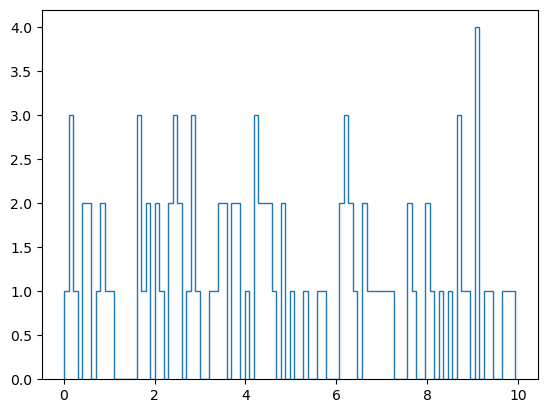

In [51]:
pdf = Flat(3, (0, 10))
pdf.generateEvents(100)
_ = plt.hist(pdf.getMass(), bins=100, histtype="step")
pdf.getMass()